In [17]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import inspect
import logging
import os
import pandas as pd
from csrank.util import setup_logging, print_dictionary
from result_script import *

from csrank.experiments import CHOICE_FUNCTIONS, CHOICE_MODELS
from csrank.constants import CHOICE_FUNCTION
import numpy as np

In [22]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results_choice.log')
FOLDER = "journalresults"
latex_path = os.path.join(DIR_PATH, FOLDER, 'choice_functions.tex')
df_path_combined = os.path.join(DIR_PATH, FOLDER , "ChoiceFunctions.csv")

setup_logging(log_path=log_path, level=logging.ERROR)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_choice', 'mnist_choice', 'letor_choice', 'exp_choice']

learning_problem = CHOICE_FUNCTION
learning_model =  learners_map[learning_problem]
models_dict = dict(zip(CHOICE_FUNCTIONS, CHOICE_MODELS))

In [23]:
import re
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]]
    return x
def create_final_result(dataset, dataset_function=get_combined_results ,latex_row=False):
    df_full = dataset_function(dataset, logger, learning_problem, latex_row=latex_row)
    data = []
    for dataset, df in df_full.groupby(['Dataset']):
        for m in CHOICE_FUNCTIONS:
            row = df[df[learning_model].str.contains(m)].values
            onerow = None
            if len(row) > 1:
                if dataset_function==get_combined_results:
                    values = np.array([get_val(val[2]) for val in row])
                else:
                    values = np.array([[val[2], val[2] - val[7]] for val in row])
                maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0][0]
                logger.error("dataset {} model {}, vals {}, maxi {}".format(dataset, row[:, 1], values, maxi))
                row = row[maxi]
                row[1] = models_dict[m]
                onerow = row

            elif len(row)==1:
                row[0][1] = models_dict[m]
                onerow = row[0]
            if onerow is not None:
                onerow[0] = get_dataset_name(onerow[0])
                data.append(onerow)
    columns = df_full.columns
    dataframe = pd.DataFrame(data, columns=columns)
    dataframe = dataframe.sort_values(by=[columns[0], columns[2]], ascending=[True, False])
    return dataframe

In [24]:
d = datasets[3]

df = create_final_result(d, latex_row=False)
searchFor = ["5 Objects", "Critique"]
df = df[~df.Dataset.str.contains('|'.join(searchFor))]
df

,Dataset,ChoiceModel,$F_1$-measure,Precision,Recall,Subset $0/1$ Accuracy,HammingAccuracy,Informedness,AUC-Score,AveragePrecisionScore
6,Expedia 10 Objects,SDA-Dropout,0.204±0.005,0.138±0.003,0.557±0.021,0.017±0.002,0.783±0.006,0.356±0.015,0.711±0.008,0.383±0.010
1,Expedia 10 Objects,FATE-Net,0.198±0.006,0.133±0.005,0.546±0.015,0.018±0.002,0.782±0.010,0.346±0.010,0.707±0.007,0.378±0.008
4,Expedia 10 Objects,SDA,0.197±0.003,0.136±0.013,0.577±0.046,0.013±0.003,0.776±0.009,0.346±0.009,0.707±0.009,0.372±0.007
0,Expedia 10 Objects,FETA-Net,0.186±0.001,0.119±0.002,0.590±0.018,0.009±0.002,0.727±0.014,0.322±0.003,0.688±0.001,0.354±0.001
2,Expedia 10 Objects,FETA-Linear,0.179±0.007,0.121±0.006,0.539±0.011,0.020±0.002,0.765±0.015,0.324±0.006,0.696±0.007,0.367±0.010
3,Expedia 10 Objects,FATE-Linear,0.168±0.005,0.114±0.009,0.510±0.011,0.018±0.009,0.769±0.011,0.306±0.010,0.695±0.012,0.354±0.010
7,Expedia 10 Objects,RankNet,0.167±0.017,0.101±0.012,0.638±0.046,0.003±0.001,0.650±0.062,0.278±0.034,0.716±0.006,0.363±0.005
8,Expedia 10 Objects,PairwiseSVM,0.129±0.017,0.077±0.013,0.703±0.149,0.004±0.002,0.481±0.227,0.165±0.097,0.680±0.051,0.321±0.048
9,Expedia 10 Objects,GenLinearModel,0.107±0.001,0.059±0.001,0.992±0.013,0.000±0.000,0.069±0.018,0.004±0.007,0.503±0.102,0.192±0.050
10,Expedia 10 Objects,AllPositive,0.106±0.000,0.058±0.000,1.000±0.000,0.000±0.000,0.058±0.000,0.000±0.000,0.500±0.000,0.058±0.000


In [25]:
import copy
from csrank.experiments.constants import FETALINEAR_CHOICE, FATELINEAR_CHOICE,SDA_CHOICE_DROPOUT, SDA_CHOICE_FIXED
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, get_combined_results_plot ,latex_row=False)
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)

searchFor = ["5 Objects", "Critique"]
df = dataFrame[~dataFrame.Dataset.str.contains('|'.join(searchFor))]
df.replace(to_replace=r' 10 Objects', value='', regex=True, inplace=True)
df.replace(to_replace=r'LETOR-', value='LETOR\n', regex=True, inplace=True)
df.replace(to_replace=r'MNIST-', value='MNIST\n', regex=True, inplace=True)
df.replace(to_replace=r'Pareto-', value='Pareto\n', regex=True, inplace=True)

#searchFor = [models_dict[FETALINEAR_CHOICE], models_dict[FATELINEAR_CHOICE]]
searchFor = [models_dict[SDA_CHOICE_FIXED]]
df = df[~df[learning_model].str.contains('|'.join(searchFor))]
df.Dataset.unique(), df[learning_model].unique()

(array(['Pareto\nfront-2D', 'Pareto\nfront-5D', 'MNIST\nMode',
        'MNIST\nUnique', 'LETOR\nMQ2007', 'LETOR\nMQ2008', 'Expedia'],
       dtype=object),
 array(['FETA-Net', 'FATE-Net', 'SDA-Dropout', 'SDA', 'FATE-Linear',
        'FETA-Linear', 'RankNet', 'PairwiseSVM', 'GenLinearModel',
        'AllPositive'], dtype=object))

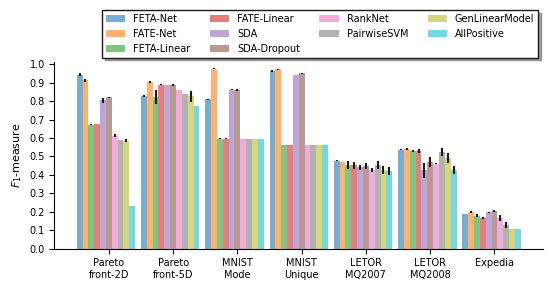

In [26]:
from csrank.constants import DISCRETE_CHOICE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
# create plot
extension = 'pdf'
fname = os.path.join(DIR_PATH, FOLDER, "{}_{}.{}")
start = 0.0
ncols = 4
params = dict(loc='lower right', bbox_to_anchor=(1.0, 1), ncol=ncols, fancybox=False, shadow=True,
                facecolor='white', edgecolor='k', fontsize=7)
plts = bar_plot_for_problem2(df, learning_problem, start, params, extension)

In [7]:
import copy
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, latex_row=False)
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame.to_csv(df_path_combined)
dataFrame

,Dataset,ChoiceModel,$F_1$-measure,Precision,Recall,Subset $0/1$ Accuracy,HammingAccuracy,Informedness,AUC-Score,AveragePrecisionScore
0,Pareto-front,FETA-Net,0.942±0.008,0.938±0.007,0.967±0.013,0.680±0.028,0.985±0.002,0.956±0.012,0.999±0.000,0.996±0.000
1,Pareto-front,FATE-Net,0.912±0.009,0.919±0.015,0.926±0.005,0.506±0.037,0.975±0.003,0.911±0.006,0.996±0.001,0.984±0.003
2,Pareto-front,FETA-Linear,0.673±0.001,0.697±0.023,0.748±0.023,0.064±0.007,0.913±0.003,0.694±0.015,0.955±0.000,0.865±0.000
3,Pareto-front,FATE-Linear,0.673±0.000,0.683±0.019,0.761±0.018,0.059±0.005,0.911±0.003,0.704±0.012,0.955±0.000,0.865±0.000
4,Pareto-front,RankNet,0.612±0.007,0.624±0.026,0.772±0.029,0.060±0.010,0.877±0.011,0.672±0.014,0.971±0.006,0.891±0.019
...,...,...,...,...,...,...,...,...,...,...
59,Expedia 10 Objects,FATE-Linear,0.168±0.005,0.114±0.009,0.510±0.011,0.018±0.009,0.769±0.011,0.306±0.010,0.695±0.012,0.354±0.010
60,Expedia 10 Objects,RankNet,0.167±0.017,0.101±0.012,0.638±0.046,0.003±0.001,0.650±0.062,0.278±0.034,0.716±0.006,0.363±0.005
61,Expedia 10 Objects,PairwiseSVM,0.129±0.017,0.077±0.013,0.703±0.149,0.004±0.002,0.481±0.227,0.165±0.097,0.680±0.051,0.321±0.048
62,Expedia 10 Objects,GenLinearModel,0.107±0.001,0.059±0.001,0.992±0.013,0.000±0.000,0.069±0.018,0.004±0.007,0.503±0.102,0.192±0.050


In [8]:
import string
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]*1e-3]
    return x
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[[learning_model, col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df[learning_model] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [9]:
import re

def create_latex(df):
    grouped = df.groupby(['Dataset'])
    code = ""
    for name, group in grouped:
        print("############################################################################")
        print("Dataset {}\n".format(name))
        code = code + "\n\t\tName {} \t\t\n\n".format(name)
        custom_dict = dict()
        for i, m in enumerate(CHOICE_MODELS):
            custom_dict[m] = i
        group['rank'] = group[learning_model].map(custom_dict)
        group.sort_values(by='rank', inplace=True)
        del group["Dataset"]
        del group['rank']
        group = mark_best(group)
        group[learning_model].replace(to_replace=['GeneralizedLinearModel'], value='glm',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Net'], value='fatenet',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Net'], value='fetanet',inplace=True)
        group[learning_model].replace(to_replace=['RankNet-Choice'], value='ranknet',inplace=True)
        group[learning_model].replace(to_replace=['PairwiseSVM'], value='pairwisesvm',inplace=True)
        group[learning_model].replace(to_replace=['AllPositive'], value='allpositive',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Linear'], value='fatelinear',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Linear'], value='fetalinear',inplace=True)
        del group['HammingAccuracy']
        del group['Precision']
        del group['Recall']
        del group['AveragePrecisionScore']
        latex_code = group.to_latex(index = False)
        latex_code = latex_code.replace(' ',"")
        latex_code = latex_code.replace('&'," & ")
        latex_code = str(latex_code)
        for learner in group[learning_model]:
            latex_code = latex_code.replace(learner, "\\{}".format(learner))
        latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
        latex_code = latex_code.replace("\\$", "$")
        latex_code = latex_code.replace("\\_", "_")
        code = code + latex_code
    return code
code = ""
for dataset in datasets:
    df = create_final_result(dataset, latex_row=True)
    df.sort_values(by='Dataset')
    code = code + create_latex(df)
f= open(latex_path,"w+")
f.write(code)
f.close()

############################################################################
Dataset Pareto-front

############################################################################
Dataset Mode

############################################################################
Dataset Unique

############################################################################
Dataset LETOR MQ2007 10 Objects

############################################################################
Dataset LETOR MQ2007 5 Objects

############################################################################
Dataset LETOR MQ2008 10 Objects

############################################################################
Dataset LETOR MQ2008 5 Objects

############################################################################
Dataset Expedia 10 Objects

